In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

36


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,05690bfc0f3a3c439a3729d7eef5d8d4a639df14,loose-kiwi,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.3,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.512619,0.619874,0.593450,0.698670,0.447368,0.564732,0.385185,0.479760,COT,2
1,81b08dcf12154b949a570e2f25ceefdcced2503c,non-U-lira,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.3,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.515101,0.620947,0.590256,0.702259,0.468421,0.572231,0.370370,0.460997,COT,2
2,16efea7b47173cbd52f16b11d8eb743e544e5d76,folio-tics,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.3,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.518825,0.622839,0.595847,0.703610,0.461842,0.567570,0.387654,0.476861,COT,2
3,6e64e0e11957f527b989c94289901c4576282c49,dowdy-gulf,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,direct/helpful-output-format-few.txt,cq.txt,direct-2-shot.json,...,0.600745,0.715841,0.636581,0.747600,0.581579,0.711307,0.525926,0.626170,Direct,2
4,048d85e0edfa619e0e7b25b235c06522ced8d830,gutsy-eyot,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.3,cot/format-minimal.txt,cq.txt,cot-2-shot.json,...,0.535374,0.643005,0.601438,0.709195,0.482895,0.600529,0.429630,0.518094,COT,2


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [5]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run


In [6]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [7]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
19,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.642118,0.749716,0.666134,0.766545,0.648684,0.776322,0.555556,0.647764
16,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.638808,0.748716,0.658946,0.762757,0.657895,0.781491,0.540741,0.643805
17,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.639222,0.748642,0.662141,0.765277,0.656579,0.784169,0.535802,0.630546
18,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.639636,0.747852,0.661342,0.765014,0.650000,0.773138,0.553086,0.647349
15,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.636326,0.746978,0.663738,0.768304,0.644737,0.768149,0.535802,0.641325
21,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.634257,0.746677,0.658946,0.765879,0.644737,0.772841,0.538272,0.638221
14,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.635499,0.746294,0.658946,0.764907,0.650000,0.775508,0.535802,0.633935
12,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.637153,0.746044,0.658946,0.761481,0.653947,0.778000,0.538272,0.638353
13,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.636740,0.745510,0.661342,0.762592,0.650000,0.775126,0.535802,0.637127
22,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.630947,0.744642,0.648562,0.757275,0.650000,0.780948,0.540741,0.637461


In [8]:
df['params.qa.system_prompt'].unique()

array(['cot/format-minimal', 'cot/format-think',
       'cte/excellent-format-few', 'direct/helpful-output-format-few',
       'direct/minimal-output-format-few'], dtype=object)

In [9]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,0.536478,0.644726,0.602769,0.711864,0.491228,0.607840,0.416461,0.506396
1,COT,cot/format-minimal,cq,cot-2-shot,0.3,0.537305,0.644080,0.602236,0.709179,0.493860,0.608937,0.418107,0.508783
2,COT,cot/format-think,cq,cot-2-shot,0.1,0.521445,0.627994,0.592119,0.698853,0.470175,0.585013,0.399177,0.489599
3,COT,cot/format-think,cq,cot-2-shot,0.3,0.515515,0.621220,0.593184,0.701513,0.459211,0.568178,0.381070,0.472539
4,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.636464,0.745949,0.659744,0.762993,0.651316,0.776211,0.536626,0.636472


In [10]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
5,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.638119,0.748112,0.661608,0.765446,0.653070,0.777937,0.537449,0.638559
8,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,0.607227,0.717269,0.641906,0.748478,0.596053,0.716336,0.520988,0.622539
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,0.536478,0.644726,0.602769,0.711864,0.491228,0.607840,0.416461,0.506396


## Visualizations

In [11]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["few_shot_examples"].map(str)
    )

    return dataf


In [12]:
def plot_variance(dataf, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [13]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
zero_shot_mask = prepared_df["few_shot_examples"] == 'empty'
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,1,0.534961,0.641767,cot/format-minimal | cq | cot-2-shot
1,COT,cot/format-minimal,cq,cot-2-shot,0.1,2,0.537029,0.645778,cot/format-minimal | cq | cot-2-shot
2,COT,cot/format-minimal,cq,cot-2-shot,0.1,3,0.537443,0.646634,cot/format-minimal | cq | cot-2-shot
3,COT,cot/format-minimal,cq,cot-2-shot,0.3,1,0.533719,0.640558,cot/format-minimal | cq | cot-2-shot
4,COT,cot/format-minimal,cq,cot-2-shot,0.3,2,0.542822,0.648676,cot/format-minimal | cq | cot-2-shot
5,COT,cot/format-minimal,cq,cot-2-shot,0.3,3,0.535374,0.643005,cot/format-minimal | cq | cot-2-shot
6,COT,cot/format-think,cq,cot-2-shot,0.1,1,0.518825,0.625855,cot/format-think | cq | cot-2-shot
7,COT,cot/format-think,cq,cot-2-shot,0.1,2,0.520894,0.627452,cot/format-think | cq | cot-2-shot
8,COT,cot/format-think,cq,cot-2-shot,0.1,3,0.524617,0.630675,cot/format-think | cq | cot-2-shot
9,COT,cot/format-think,cq,cot-2-shot,0.3,1,0.518825,0.622839,cot/format-think | cq | cot-2-shot


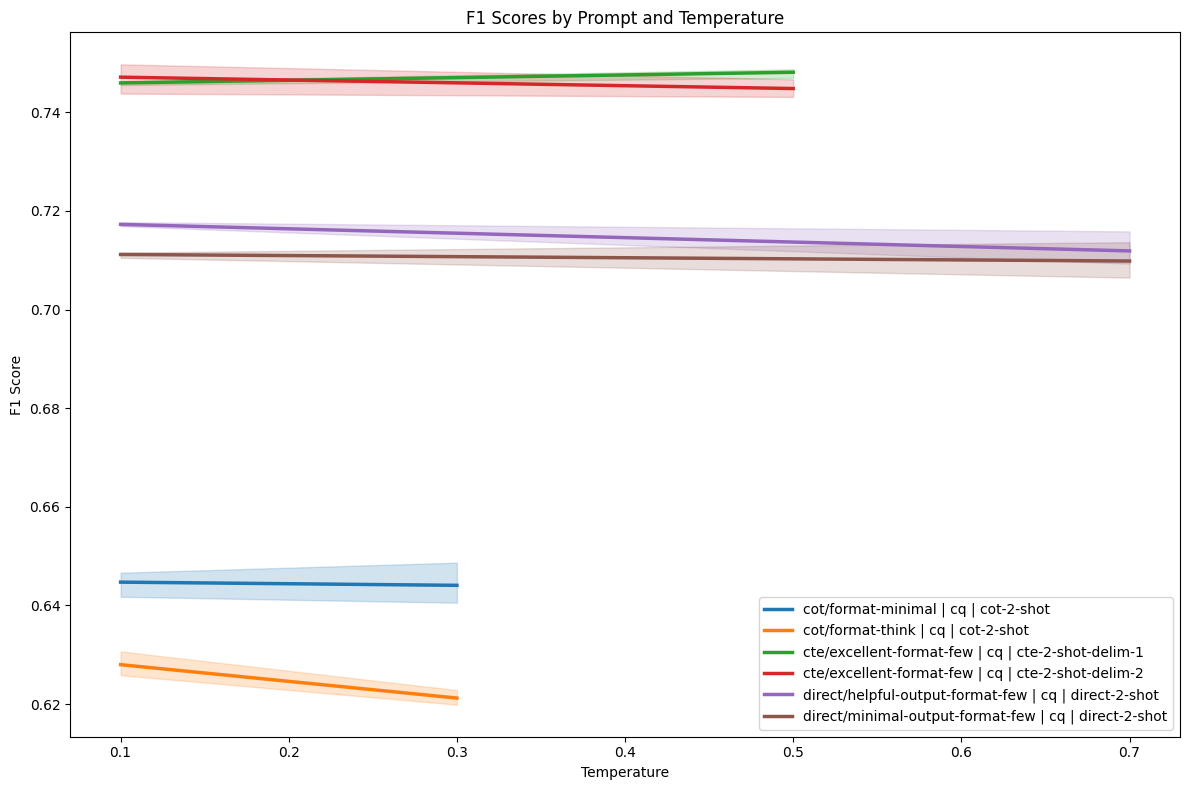

In [30]:
plot_variance(prepared_df, legend_loc='lower right')

## Statistical Testing

In [15]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [16]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    # Two-Way ANOVA
    two_way_anova(dataf)
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

### Direct technique

In [17]:
direct_prompt_mask = prepared_df["technique"] == "Direct"
direct_prompt_prepared_df = prepared_df[direct_prompt_mask & temperature_mask]
direct_prompt_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
24,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,1,0.605296,0.717192,direct/helpful-output-format-few | cq | direct...
25,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,2,0.608192,0.717716,direct/helpful-output-format-few | cq | direct...
26,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,3,0.608192,0.716897,direct/helpful-output-format-few | cq | direct...
27,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.7,1,0.598676,0.710515,direct/helpful-output-format-few | cq | direct...
28,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.7,2,0.600745,0.715841,direct/helpful-output-format-few | cq | direct...
29,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.7,3,0.596194,0.709302,direct/helpful-output-format-few | cq | direct...
30,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.1,1,0.596194,0.710489,direct/minimal-output-format-few | cq | direct...
31,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.1,2,0.597021,0.711551,direct/minimal-output-format-few | cq | direct...
32,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.1,3,0.597021,0.711460,direct/minimal-output-format-few | cq | direct...
33,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.7,1,0.594125,0.709393,direct/minimal-output-format-few | cq | direct...


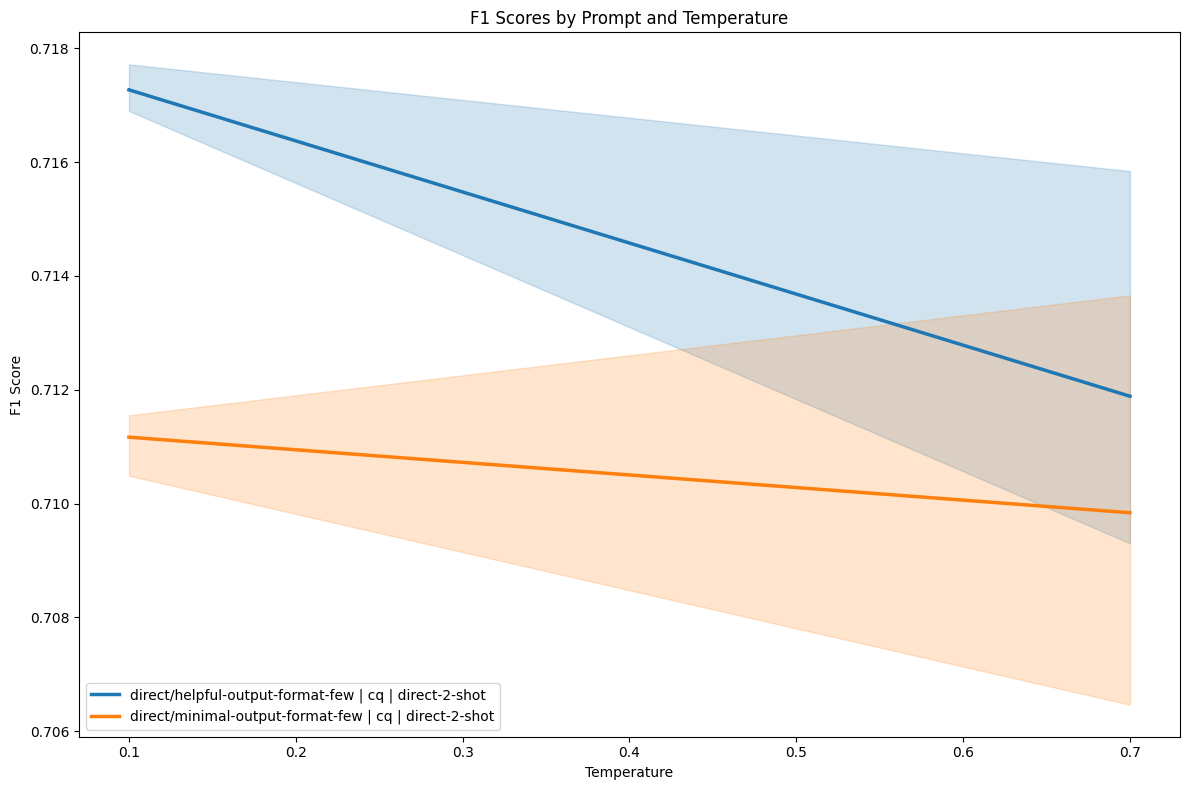

In [18]:
plot_variance(direct_prompt_prepared_df, legend='brief')

In [19]:
report(direct_prompt_prepared_df)

Prompt values
	 direct/helpful-output-format-few | cq | direct-2-shot
	 direct/minimal-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.7


Two-Way ANOVA Results:
                            sum_sq   df         F    PR(>F)
C(prompt)                 0.000050  1.0  7.751477  0.023772
C(temperature)            0.000034  1.0  5.256555  0.051048
C(prompt):C(temperature)  0.000012  1.0  1.920165  0.203242
Residual                  0.000051  8.0       NaN       NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 215.4761, p-value: 1.2532e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 0.4990, p-value: 5.1892e-01


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                               
                        group1                                                group2                        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------

In [20]:
# Tukey’s HSD
_data = direct_prompt_prepared_df.loc[~zero_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                               
                        group1                                                group2                        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------------------------------------------------
direct/helpful-output-format-few | cq | direct-2-shot direct/minimal-output-format-few | cq | direct-2-shot  -0.0041 0.0474 -0.0105 0.0024  False
-------------------------------------------------------------------------------------------------------------------------------------------------


## COT

In [21]:
cot_prompt_mask = prepared_df["technique"] == "COT"
cot_prompt_prepared_df = prepared_df[cot_prompt_mask & temperature_mask]

In [22]:
cot_prompt_prepared_df.groupby("prompt")["f1"].mean().sort_values(ascending=False)

prompt
cot/format-minimal | cq | cot-2-shot    0.644403
cot/format-think | cq | cot-2-shot      0.624607
Name: f1, dtype: float64

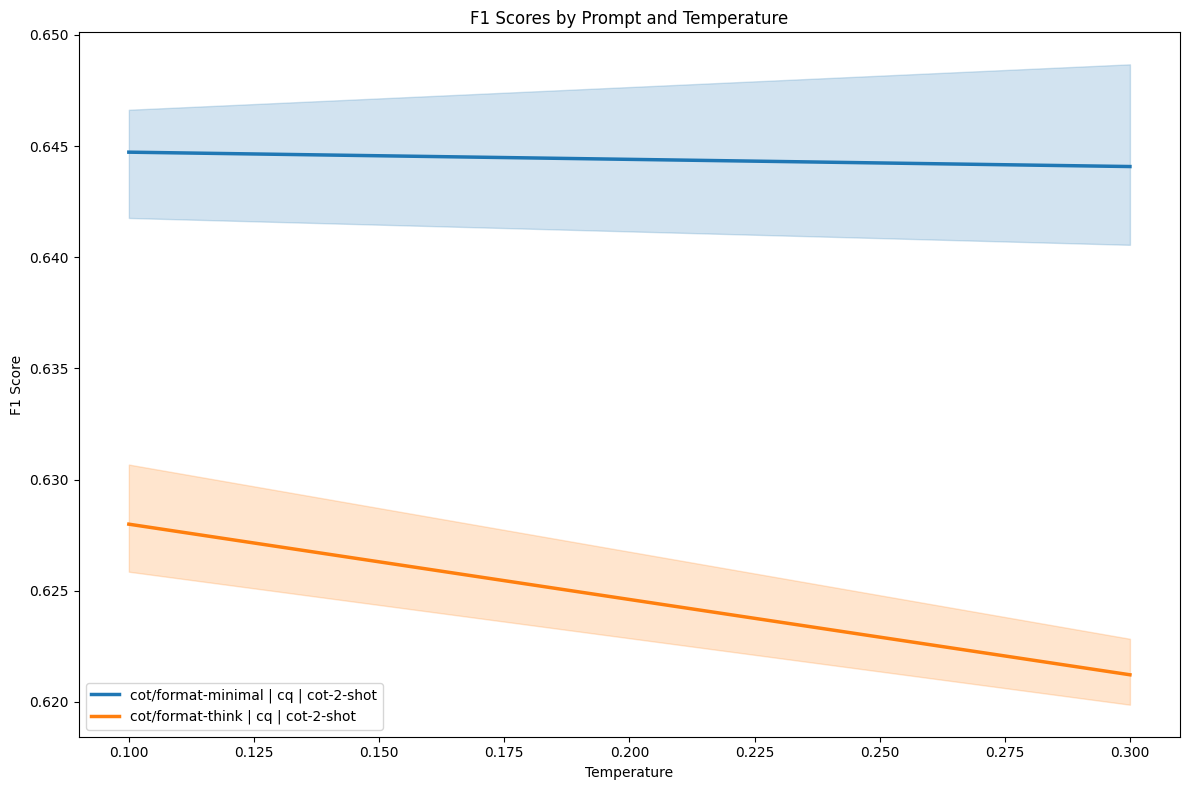

In [23]:
plot_variance(cot_prompt_prepared_df)

In [24]:
report(cot_prompt_prepared_df)

Prompt values
	 cot/format-minimal | cq | cot-2-shot
	 cot/format-think | cq | cot-2-shot


Temperature values:  0.1, 0.3


Two-Way ANOVA Results:
                            sum_sq   df           F    PR(>F)
C(prompt)                 0.001176  1.0  145.263824  0.000002
C(temperature)            0.000041  1.0    5.103260  0.053803
C(prompt):C(temperature)  0.000028  1.0    3.479506  0.099114
Residual                  0.000065  8.0         NaN       NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 65.7285, p-value: 1.2584e-03
One-Way ANOVA for Temperature 0.3:
F-statistic: 80.0083, p-value: 8.6404e-04


                             Multiple Comparison of Means - Tukey HSD, FWER=0.01                             
               group1                              group2               meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------------------------------------------------
cot/format-minimal | cq | cot-2-shot cot/format-think |

### All techniques

In [25]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_data = _data.loc[prompt_mask&temperature_mask]
best_prepared_data

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,1,0.534961,0.641767,cot/format-minimal | cq | cot-2-shot
1,COT,cot/format-minimal,cq,cot-2-shot,0.1,2,0.537029,0.645778,cot/format-minimal | cq | cot-2-shot
2,COT,cot/format-minimal,cq,cot-2-shot,0.1,3,0.537443,0.646634,cot/format-minimal | cq | cot-2-shot
3,COT,cot/format-minimal,cq,cot-2-shot,0.3,1,0.533719,0.640558,cot/format-minimal | cq | cot-2-shot
4,COT,cot/format-minimal,cq,cot-2-shot,0.3,2,0.542822,0.648676,cot/format-minimal | cq | cot-2-shot
5,COT,cot/format-minimal,cq,cot-2-shot,0.3,3,0.535374,0.643005,cot/format-minimal | cq | cot-2-shot
12,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,1,0.637153,0.746044,cte/excellent-format-few | cq | cte-2-shot-del...
13,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,2,0.636740,0.745510,cte/excellent-format-few | cq | cte-2-shot-del...
14,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,3,0.635499,0.746294,cte/excellent-format-few | cq | cte-2-shot-del...
15,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,1,0.636326,0.746978,cte/excellent-format-few | cq | cte-2-shot-del...


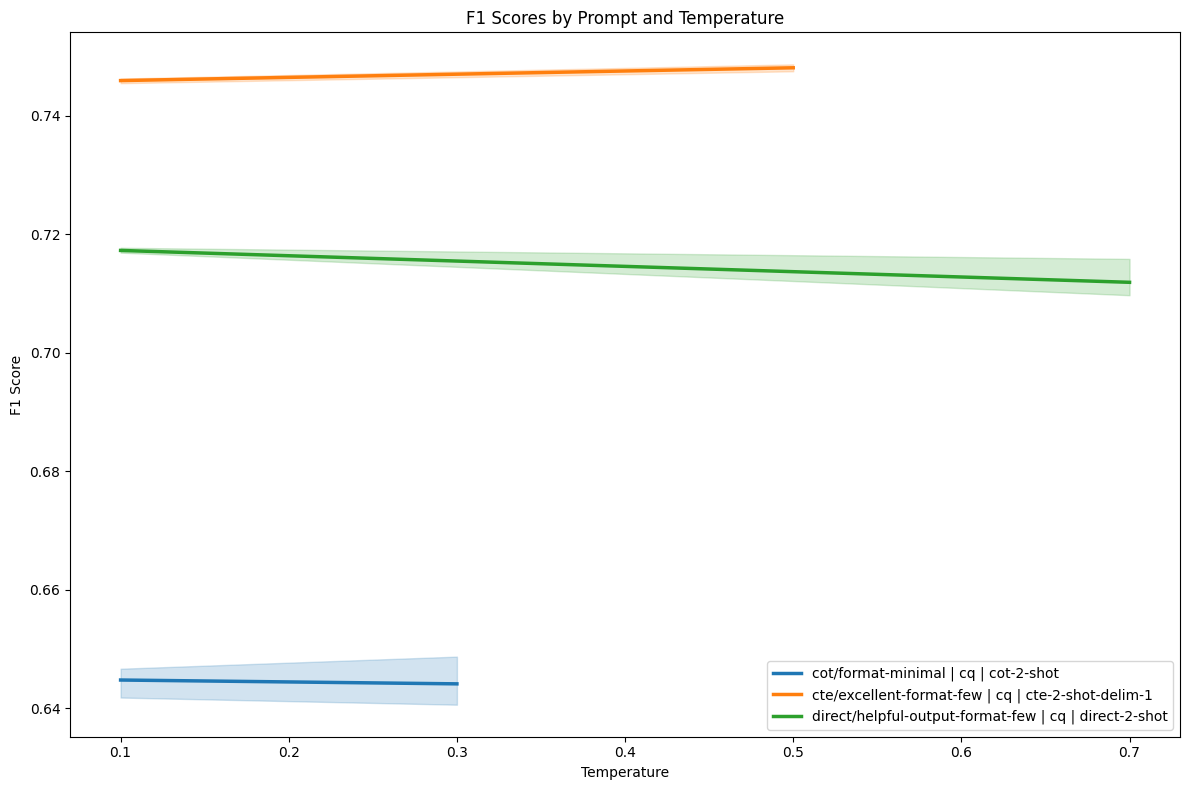

In [31]:
plot_variance(best_prepared_data, figsize=(12, 8), legend_loc='lower right')

In [27]:
report(best_prepared_data)

Prompt values
	 cot/format-minimal | cq | cot-2-shot
	 cte/excellent-format-few | cq | cte-2-shot-delim-1
	 direct/helpful-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                                sum_sq    df             F    PR(>F)
C(prompt)                          NaN   2.0           NaN       NaN
C(temperature)           -4.886045e-17   3.0 -2.606522e-12  1.000000
C(prompt):C(temperature)  1.514366e-04   6.0  4.039288e+00  0.045571
Residual                  7.498183e-05  12.0           NaN       NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 3457.9773, p-value: 6.5128e-10
Skipping temperature 0.30000000000000004: Not enough groups to perform ANOVA
Skipping temperature 0.5: Not enough groups to perform ANOVA
Skipping temperature 0.7000000000000001: Not enough groups to perform ANOVA


                                             Multiple Comparison of Means - Tukey HSD, FWER=0.01                                 

/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  warnings.warn('covariance of constraints does not have full '


## Inspect

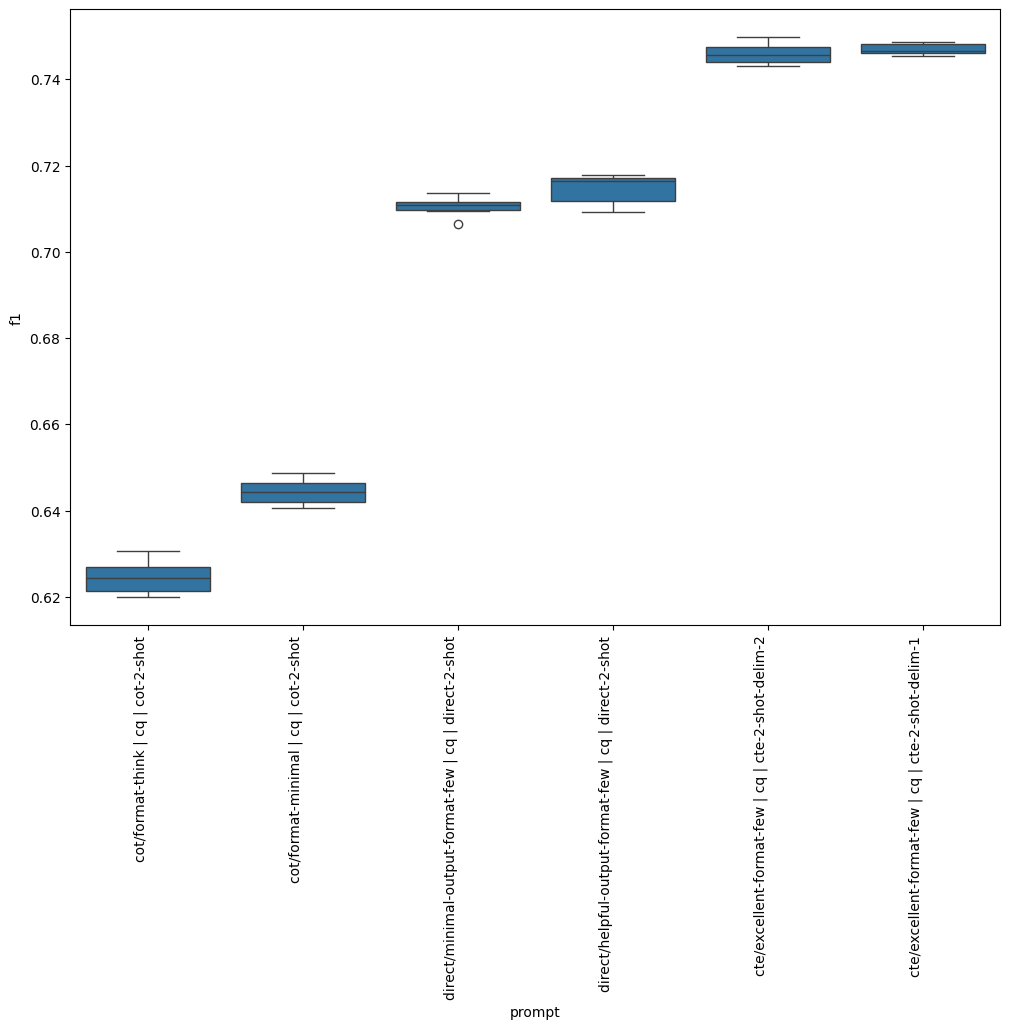

In [28]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=90, ha="right");